# Question answering with BERT (HuggingFace)

Deep learning has been revolutionized by transformer models. Transformer based models like BERT are heavily used in NLP to solve tasks due to the rich numerical representations of text they provide. Here we will be discussing how to use HuggingFace's transformers library to conveniently explore various transformer based NLP models. We will be training a question answering model on medical question and answer collected from websites ehealth, icliniq, QuestionDoctorsQA, and WebMDQA. You can download dataset at  https://github.com/LasseRegin/medical-question-answer-data

**Warning**: This a very memory intensive exercise. It is recommended to havea GPU with a large memory if running on a GPU-powered Machine. This exercise was run on a Nvidia RTX 2070 8GB with a training batch size of `4`.




## Import libraries

For reproducible purpose, we set some seed for random. We also check if there is GPU that we can use for training to use. Otherwise, we use CPU for training.

In [1]:
import random
import numpy as np
import transformers
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
from transformers import DistilBertConfig, TFDistilBertForQuestionAnswering
import tensorflow as tf
import time

def set_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
    try:
        transformers.trainer_utils.set_seed(seed)
    except NameError:
        print("Warning: transformers module is not imported. Setting the seed for transformers failed.")
        
# Fixing the random seed
random_seed=4321
set_random_seed(random_seed)

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("No GPU found!")
  pass

## Download the dataset

Datasets were downloaded from https://github.com/LasseRegin/medical-question-answer-data

## Load dataset from json file

In [2]:
import pandas as pd


I already downloaded and extract the datasests, so we only need to load it here. I use Pandas package to load JSON format

In [3]:
ehealth = pd.read_json('ehealthforumQAs.json')
icliniqQAs = pd.read_json('icliniqQAs.json')
questionDoctorQAs = pd.read_json('questionDoctorQAs.json')
webmdQAs = pd.read_json('webmdQAs.json')


We have a look at the structure of datasets. We have 3 important components: Question, Answer, and Tag. Tag is more about the category of the question. Note that Tags were not classify, so we cannot use it as it is.

In [4]:
webmdQAs

,answer,question,url,tags
0,adhd and bipolar mood disorder (bmd) can coexi...,my 5 1/2-year-old son displays adhd symptoms f...,http://answers.webmd.com/answers/1194205/my-5-...,[attention deficit hyperactivity disorder]
1,stimulants in general tend to decrease appetit...,my son has add and mild autism. he has been su...,http://answers.webmd.com/answers/1194206/my-so...,"[autism, weight loss]"
2,while any of the stimulant medications can inc...,my son is 13 and is depressed. he has been tak...,http://answers.webmd.com/answers/1198557/my-so...,[]
3,seventy percent of teens diagnosed when they a...,my 17-year-old has stopped taking concerta aft...,http://answers.webmd.com/answers/1195455/my-17...,[attention deficit hyperactivity disorder]
4,try claritin-d which is located behind the pha...,i've been taking respa-ar for allergies. i can...,http://answers.webmd.com/answers/1182576/i-ve-...,[allergy]
...,...,...,...,...
23432,to avoid unintentional overdoses among adults ...,how can accidental of acetaminophen overdose b...,http://answers.webmd.com/answers/1175997/how-c...,"[drug overdose, acetaminophen]"
23433,if you take more medication than you have been...,what should i do if i take an overdose of maxalt?,http://answers.webmd.com/answers/1168806/what-...,[drug overdose]
23434,call your doctor or poison control center or g...,what do i do in case of an overdose of relpax?,http://answers.webmd.com/answers/1168730/what-...,[drug overdose]
23435,in the u. s. suicide attempts account for over...,is overdose with acetaminophen usually acciden...,http://answers.webmd.com/answers/1175998/is-ov...,"[drug overdose, acetaminophen]"


In [5]:
questionDoctorQAs

,answer,answer_author,question,question_text,tags,url
0,you can stay assured you are fine free of hiv....,Dr. Ayman Darrag,is my anti hiv test conclusive or need retest?,Is my Anti Hiv Test Conclusive or need retest?,[hiv test],https://questiondoctors.com/is-my-anti-hiv-tes...
1,hi you are 100 % hiv free good luck,Dr Ahmed Fawzy,is my anti hiv test conclusive or need retest?,Is my Anti Hiv Test Conclusive or need retest?,[hiv test],https://questiondoctors.com/is-my-anti-hiv-tes...
2,your time slots of the tests and the final res...,Dr.Honey,is my anti hiv test conclusive or need retest?,Is my Anti Hiv Test Conclusive or need retest?,[hiv test],https://questiondoctors.com/is-my-anti-hiv-tes...
3,hi i see no labrum tear however i see acetabul...,Dr Ahmed Fawzy,i have some hip pain 9 weeks. had mra image re...,I have some hip pain 9 weeks. Had MRA image re...,[magnetic resonance angiography (mra)],https://questiondoctors.com/i-have-some-hip-pa...
4,no visible tear in labrum but obviously calcif...,Dr. Ayman Darrag,i have some hip pain 9 weeks. had mra image re...,I have some hip pain 9 weeks. Had MRA image re...,[magnetic resonance angiography (mra)],https://questiondoctors.com/i-have-some-hip-pa...
...,...,...,...,...,...,...
5674,get it confirmed by doing venous doppler of bo...,Dr Mahaveer,pain in legs – varicose veins?,Question: Pain in Legs – Varicose veins?,[],https://questiondoctors.com/question-pain-in-l...
5675,hi dear. there are very less chances of pregna...,Dr Mahaveer,headaches really tired all the time feeling na...,"Question: Headaches, really tired all the time...",[don't know if its too early to take a pregnan...,https://questiondoctors.com/question-headaches...
5676,i’m a radiologist. may be an mri misread. when...,Dr. Erik Ramonov,46 year old male had stroke on right side of b...,Question: 46 year old male had stroke on right...,[stroke on right side of brain],https://questiondoctors.com/question-46-year-o...
5677,could be reaction to oxycodone…. ”the most fre...,Jason Roberge,46 year old male had stroke on right side of b...,Question: 46 year old male had stroke on right...,[stroke on right side of brain],https://questiondoctors.com/question-46-year-o...


In [6]:
ehealth

,answer,question,url,tags
0,stopping smoking is about will power and being...,how do i stop smoking now,http://ehealthforum.com/health/stop-smoking-qu...,"[addiction, stop smoking]"
1,hello this sounds quite unfamiliar that due to...,i had a tubaligation 4 years ago and also have...,http://ehealthforum.com/health/endometriosis-q...,"[pregnancy, diet, endometriosis]"
2,extra caffeine can cause gastric discomfort th...,could extra caffeine consumption be a cause of...,http://ehealthforum.com/health/caffeine-consum...,"[breast cancer, cancer, breasts]"
3,hello thanks for submitting your question here...,"hello- i am a 24 year old female 5""4 & 115 lb ...",http://ehealthforum.com/health/pcos-one-ovary-...,"[hair loss, diet, acne, ovulation and ovaries]"
4,i am glad to help you out. this is not possibl...,i was wanting to know if you could tell me if ...,http://ehealthforum.com/health/not-knowing-you...,"[am i pregnant, pregnant, urine pregnancy test..."
...,...,...,...,...
166,what your boyfriend seems to be having is bipo...,i belive my boyfriend is bipolar or has boderl...,http://ehealthforum.com/health/one-minute-he-s...,"[smoking pot, bipolar, smoking, abusive, bipol..."
167,depression is common with any comorbid illness...,why do i feel so down when someone makes fun o...,http://ehealthforum.com/health/feel-down-about...,[dyslexia]
168,in bipolar disorder sometimes there are mixed ...,please help! my fiance is bipolar but will not...,http://ehealthforum.com/health/fiance-is-bipol...,"[bipolar, medication, bipolar help, anger help..."
169,hello. from your description here it seems you...,i constantly have bursts of anger for no reaso...,http://ehealthforum.com/health/constantly-have...,"[bipolar disorder, anxiety, bipolar, angry, an..."


In [7]:
icliniqQAs

,answer,question,question_text,tags,url
0,from your description it appears that you may ...,is it fine to exercise with knee pain?,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 24 ye...",[exercises],https://www.icliniq.com/qa/knee-pain/is-it-fin...
1,depression anxiety restlessness and panic atta...,suffering from anxiety restlessness and taking...,"\r\n\r\n\r\n\t\t\t\t\tDear Doctor,\nI am suffe...",[anxiety],https://www.icliniq.com/qa/anxiety/suffering-f...
2,patients with hypothyroidism usually gain weig...,can a thyroid patient eat soybean and fenugreek?,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,I am a 23 year...",[hypothyroidism],https://www.icliniq.com/qa/thyroid-problem/can...
3,fenugreek seed cannot affect your fertility do...,i am not getting my periods after taking fenug...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am a 23 ye...",[delayed period],https://www.icliniq.com/qa/missed-period/i-am-...
4,your problem is a characteristic of cholinergi...,kindly suggest me a therapy to overcome heat a...,"\r\n\r\n\r\n\t\t\t\t\tHello doctor,\nFrom one ...",[levocetirizine],https://www.icliniq.com/qa/cholinergic-urticar...
...,...,...,...,...,...
460,i assure you not to worry as everything is goi...,i had unprotected sex and got ulcer in scrotum...,"\r\n\r\n\r\n\t\t\t\t\tHi doctor,\nI am having ...",[unprotected sex],https://www.icliniq.com/qa/sexually-transmitte...
461,com. at this moment you can take another 0. 5m...,i have anxiety disorder and was prescribed wit...,"\r\n\r\n\r\n\t\t\t\t\tDear Doctor,\nI have pan...",[anxiety],https://www.icliniq.com/qa/anxiety-disorder/i-...
462,if she is in her ovulation period then better ...,had unprotected sex today. should my partner t...,"\r\n\r\n\r\n\t\t\t\t\tHello doctor,\nI had unp...",[unprotected sex],https://www.icliniq.com/qa/unprotected-sex/had...
463,i assume that you are having good life with cu...,suffering from anxiety attacks which are of a ...,"\r\n\r\n\r\n\t\t\t\t\tDear Doctor,\nI am being...",[anxiety],https://www.icliniq.com/qa/anxiety-attacks/suf...


Alright, we need to combine all the datasets to one for training and testing. Let's say it is all_QA data

In [8]:
con_QAs = [icliniqQAs.loc[:,["question", "answer", "tags"]],questionDoctorQAs.loc[:,["question", "answer", "tags"]],ehealth.loc[:,["question", "answer", "tags"]],webmdQAs.loc[:,["question", "answer", "tags"]]]

In [9]:
all_QA = pd.concat(con_QAs, ignore_index = True)
all_QA

,question,answer,tags
0,is it fine to exercise with knee pain?,from your description it appears that you may ...,[exercises]
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
2,can a thyroid patient eat soybean and fenugreek?,patients with hypothyroidism usually gain weig...,[hypothyroidism]
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period]
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine]
...,...,...,...
29747,how can accidental of acetaminophen overdose b...,to avoid unintentional overdoses among adults ...,"[drug overdose, acetaminophen]"
29748,what should i do if i take an overdose of maxalt?,if you take more medication than you have been...,[drug overdose]
29749,what do i do in case of an overdose of relpax?,call your doctor or poison control center or g...,[drug overdose]
29750,is overdose with acetaminophen usually acciden...,in the u. s. suicide attempts account for over...,"[drug overdose, acetaminophen]"


In [10]:
all_QA['question'] = all_QA['question'].str.strip()
all_QA['answer'] = all_QA['answer'].str.strip()
all_QA['context'] = all_QA['question'] + " " + all_QA['answer']
all_QA

,question,answer,tags,context
0,is it fine to exercise with knee pain?,from your description it appears that you may ...,[exercises],is it fine to exercise with knee pain? from yo...
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety],suffering from anxiety restlessness and taking...
2,can a thyroid patient eat soybean and fenugreek?,patients with hypothyroidism usually gain weig...,[hypothyroidism],can a thyroid patient eat soybean and fenugree...
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period],i am not getting my periods after taking fenug...
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine],kindly suggest me a therapy to overcome heat a...
...,...,...,...,...
29747,how can accidental of acetaminophen overdose b...,to avoid unintentional overdoses among adults ...,"[drug overdose, acetaminophen]",how can accidental of acetaminophen overdose b...
29748,what should i do if i take an overdose of maxalt?,if you take more medication than you have been...,[drug overdose],what should i do if i take an overdose of maxa...
29749,what do i do in case of an overdose of relpax?,call your doctor or poison control center or g...,[drug overdose],what do i do in case of an overdose of relpax?...
29750,is overdose with acetaminophen usually acciden...,in the u. s. suicide attempts account for over...,"[drug overdose, acetaminophen]",is overdose with acetaminophen usually acciden...


## There are some contraction format in the Q and A, we need to replace them to the normal form

In [11]:
import re
#preprocessing questions and answers.
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"<link>", "", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def preprocess(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = text.lower()
    text = text.strip()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('>','',text)
    return text


all_QA['preprocessed_question'] = all_QA['question'].apply(preprocess)
all_QA['preprocessed_answer'] = all_QA['answer'].apply(preprocess)
all_QA.head()

,question,answer,tags,context,preprocessed_question,preprocessed_answer
0,is it fine to exercise with knee pain?,from your description it appears that you may ...,[exercises],is it fine to exercise with knee pain? from yo...,is it fine to exercise with knee pain,from your description it appears that you may ...
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety],suffering from anxiety restlessness and taking...,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...
2,can a thyroid patient eat soybean and fenugreek?,patients with hypothyroidism usually gain weig...,[hypothyroidism],can a thyroid patient eat soybean and fenugree...,can a thyroid patient eat soybean and fenugreek,patients with hypothyroidism usually gain weig...
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period],i am not getting my periods after taking fenug...,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine],kindly suggest me a therapy to overcome heat a...,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...


In [12]:
all_QA['preprocessed_question'] = all_QA['preprocessed_question'].str.strip()
all_QA['preprocessed_answer'] = all_QA['preprocessed_answer'].str.strip()
all_QA['context'] = all_QA['preprocessed_question'] + all_QA['preprocessed_answer']

## Find the length of questions and answers. It is needed for training to reduce the memory for unnecessary tasks. Why? Because we will use BERT model and transfer it to our data. BERT (we is going to use) can handle max length of sequence of 512. If our data has shorter, we use need to reduce the max length. If we have longer, we may need to find other models that can take care of it or we must truncated our data (questions and answers)

We are looking for some statistics to see the length of questions and answers. It will give us some clues what to choose for max length of sentences.

In [13]:


#finding the lens of preprocessed questions and answers
all_QA['question_len']=all_QA['preprocessed_question'].apply(lambda x: len(x.split(' ')))
all_QA['answer_len']=all_QA['preprocessed_answer'].apply(lambda x: len(x.split(' ')))
     


Length of sentences by percentile

In [14]:
all_QA['question_len'].quantile([.1,.25,.50,.75,.90,.99])

0.10      7.0
0.25     11.0
0.50     18.0
0.75     49.0
0.90     96.0
0.99    124.0
Name: question_len, dtype: float64

In [15]:
all_QA['question_len'].max()

425

In [16]:
all_QA['answer_len'].max()

1333

In [17]:
all_QA['answer_len'].quantile([.1,.25,.50,.75,.90,.99])

0.10     21.0
0.25     35.0
0.50     61.0
0.75    114.0
0.90    200.9
0.99    495.0
Name: answer_len, dtype: float64

Some answers are very long, however, they are mostly less than 495 and the question is no longer than 425. So, we will use max length for training as 495.

## We use max length of Q and A as 495.

Thus, we need to cut any answers that is longer than 495 to 495.

In [18]:
all_QA['truncated_question']=all_QA.apply(lambda x: ' '.join(x.preprocessed_question.split(' ')[:124]) if x.question_len>124 else x.preprocessed_question ,axis=1)
all_QA['truncated_answer']=all_QA.apply(lambda x: ' '.join(x.preprocessed_answer.split(' ')[:495]) if x.answer_len>495 else x.preprocessed_answer ,axis=1)


In [19]:
all_QA['truncated_answer'] = all_QA['truncated_answer'].str.strip()
all_QA['truncated_question'] = all_QA['truncated_question'].str.strip()

Let's call our truncated data now as dat_QA

In [20]:
dat_QA = all_QA.loc[:,['truncated_question','truncated_answer','tags']]
dat_QA

,truncated_question,truncated_answer,tags
0,is it fine to exercise with knee pain,from your description it appears that you may ...,[exercises]
1,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
2,can a thyroid patient eat soybean and fenugreek,patients with hypothyroidism usually gain weig...,[hypothyroidism]
3,i am not getting my periods after taking fenug...,fenugreek seed cannot affect your fertility do...,[delayed period]
4,kindly suggest me a therapy to overcome heat a...,your problem is a characteristic of cholinergi...,[levocetirizine]
...,...,...,...
29747,how can accidental of acetaminophen overdose b...,to avoid unintentional overdoses among adults ...,"[drug overdose, acetaminophen]"
29748,what should i do if i take an overdose of maxalt,if you take more medication than you have been...,[drug overdose]
29749,what do i do in case of an overdose of relpax,call your doctor or poison control center or g...,[drug overdose]
29750,is overdose with acetaminophen usually acciden...,in the u s suicide attempts account for over t...,"[drug overdose, acetaminophen]"


# We want to know how many different tags we have in the data

In [21]:
s = set.intersection(set(['anxiety', "head"]), set(['anxiety', "head"]))

In [22]:
list(s)

['head', 'anxiety']

In [23]:
dat_QA.shape[0]

29752

In [24]:
tags = []
tags.append("2")
tags

['2']

In [25]:
tags = []
for i in range(dat_QA.shape[0]):
    tags.extend(dat_QA.iloc[i,2])

In [26]:
import collections

In [27]:
tags

['exercises',
 'anxiety',
 'hypothyroidism',
 'delayed period',
 'levocetirizine',
 'antibiotics',
 'physiotherapy',
 'diabetes',
 'vitiligo',
 'constipation',
 'complete blood count',
 'genetic inheritance',
 'vitiligo',
 'thyroid problem',
 'thyroid problem',
 'vitiligo',
 'premature ejaculation',
 'constipation',
 'premature ejaculation',
 'thyroid problem',
 'premature ejaculation',
 'premature ejaculation',
 'premature ejaculation',
 'premature ejaculation',
 'premature ejaculation',
 'premature ejaculation',
 'thyroid problem',
 'vitiligo',
 'premature ejaculation',
 'thyroid problem',
 'thyroid problem',
 'complete blood count',
 'premature ejaculation',
 'complete blood count',
 'constipation',
 'vitiligo',
 'complete blood count',
 'constipation',
 'constipation',
 'levocetirizine',
 'levocetirizine',
 'constipation',
 'genetic inheritance',
 'levocetirizine',
 'genetic inheritance',
 'constipation',
 'genetic inheritance',
 'levocetirizine',
 'levocetirizine',
 'liver functio

In [28]:
counter = collections.Counter(tags)
counter

Counter({'exercises': 9,
         'anxiety': 394,
         'hypothyroidism': 82,
         'delayed period': 8,
         'levocetirizine': 7,
         'antibiotics': 6,
         'physiotherapy': 7,
         'diabetes': 222,
         'vitiligo': 6,
         'constipation': 66,
         'complete blood count': 8,
         'genetic inheritance': 8,
         'thyroid problem': 6,
         'premature ejaculation': 20,
         'liver function test': 3,
         'fungal infection': 7,
         'acne scars': 6,
         'salicylic acid': 11,
         'allergy': 168,
         'selective serotonin reuptake inhibitors': 6,
         'baby constipation': 8,
         'dental scaling': 6,
         'missed period': 12,
         'arrhythmias': 5,
         'coronary artery disease': 2,
         'angiography': 2,
         'omega fatty acids': 7,
         'tingling sensation': 7,
         'tachycardia': 18,
         'vaginal bleeding': 6,
         'rheumatoid arthritis': 30,
         'tooth decay': 10,
  

In [29]:
most_tags = counter.most_common(50)
most_tags

[('pregnancy', 2930),
 ('period', 1384),
 ('pain', 1274),
 ('exercise', 890),
 ('sexual intercourse', 809),
 ('coldness', 670),
 ('skin', 646),
 ('vision', 638),
 ('drug', 571),
 ('fever', 502),
 ('baby', 496),
 ('stomach', 493),
 ('burn', 482),
 ('nausea', 436),
 ('penis', 419),
 ('vagina', 418),
 ('drinking', 415),
 ('surgery', 409),
 ('injection', 408),
 ('anxiety', 394),
 ('weight', 385),
 ('diet', 374),
 ('rash', 367),
 ('food', 365),
 ('antibiotic', 361),
 ('condom', 353),
 ('ears', 351),
 ('flu', 348),
 ('swelling', 344),
 ('smoking', 337),
 ('headache', 335),
 ('hand', 316),
 ('ejaculation', 313),
 ('eyes', 312),
 ('birth control', 307),
 ('diarrhea', 302),
 ('head', 289),
 ('leg', 288),
 ('shingles', 287),
 ('cough', 283),
 ('breast', 279),
 ('arm', 278),
 ('high blood pressure', 271),
 ('virus', 270),
 ('acne', 264),
 ('insurance', 261),
 ('pregnancy test', 252),
 ('chest', 249),
 ('foot', 241),
 ('stress', 229)]

In [30]:
most_tags[0][0]

'pregnancy'

In [31]:
most_tags_list = [tag[0] for tag in most_tags]
most_tags_list

['pregnancy',
 'period',
 'pain',
 'exercise',
 'sexual intercourse',
 'coldness',
 'skin',
 'vision',
 'drug',
 'fever',
 'baby',
 'stomach',
 'burn',
 'nausea',
 'penis',
 'vagina',
 'drinking',
 'surgery',
 'injection',
 'anxiety',
 'weight',
 'diet',
 'rash',
 'food',
 'antibiotic',
 'condom',
 'ears',
 'flu',
 'swelling',
 'smoking',
 'headache',
 'hand',
 'ejaculation',
 'eyes',
 'birth control',
 'diarrhea',
 'head',
 'leg',
 'shingles',
 'cough',
 'breast',
 'arm',
 'high blood pressure',
 'virus',
 'acne',
 'insurance',
 'pregnancy test',
 'chest',
 'foot',
 'stress']

In [32]:
all_QA['tags_100']=all_QA.apply(lambda x: list(set.intersection(set(x.tags), set(most_tags_list))) ,axis=1)

# for i in range(all_QA.shape[0]):
#     all_QA['tags_100'][i] = list(set.intersection(set(all_QA['tags'][i]), set(most_tags_list)))

In [33]:
all_QA.iloc[100:200]

,question,answer,tags,context,preprocessed_question,preprocessed_answer,question_len,answer_len,truncated_question,truncated_answer,tags_100
100,how to get relief from dandruff?,the causes of dandruff are any of the followin...,[salicylic acid],how to get relief from dandruffthe causes of d...,how to get relief from dandruff,the causes of dandruff are any of the followin...,6,101,how to get relief from dandruff,the causes of dandruff are any of the followin...,[]
101,i have developed hair dye allergy. please help.,as per the details given it seems that you hav...,[allergy],i have developed hair dye allergy please helpa...,i have developed hair dye allergy please help,as per the details given it seems that you hav...,8,111,i have developed hair dye allergy please help,as per the details given it seems that you hav...,[]
102,while treating a patient for depression when c...,you seem to be dealing with a patient with tre...,[selective serotonin reuptake inhibitors],while treating a patient for depression when c...,while treating a patient for depression when c...,you seem to be dealing with a patient with tre...,12,143,while treating a patient for depression when c...,you seem to be dealing with a patient with tre...,[]
103,i have twin baby girls. one of them is not gai...,keep trying to give breast feeds as much as po...,[baby constipation],i have twin baby girls one of them is not gain...,i have twin baby girls one of them is not gain...,keep trying to give breast feeds as much as po...,14,210,i have twin baby girls one of them is not gain...,keep trying to give breast feeds as much as po...,[]
104,my 4 month baby has not passed stools. please ...,it is common to have decrease in stool frequen...,[baby constipation],my 4 month baby has not passed stools please h...,my 4 month baby has not passed stools please help,it is common to have decrease in stool frequen...,10,130,my 4 month baby has not passed stools please help,it is common to have decrease in stool frequen...,[]
...,...,...,...,...,...,...,...,...,...,...,...
195,why does running nose sneezing and blocked nos...,i have gone through your query and can underst...,[fexofenadine],why does running nose sneezing and blocked nos...,why does running nose sneezing and blocked nos...,i have gone through your query and can underst...,9,127,why does running nose sneezing and blocked nos...,i have gone through your query and can underst...,[]
196,what is the reason for my disturbed sleep and ...,i have gone through your query. you are suffer...,[fexofenadine],what is the reason for my disturbed sleep and ...,what is the reason for my disturbed sleep and ...,i have gone through your query you are sufferi...,11,290,what is the reason for my disturbed sleep and ...,i have gone through your query you are sufferi...,[]
197,i had sex in the 5th week of pregnancy and saw...,at five weeks of pregnancy if you have had int...,[vaginal bleeding],i had sex in the 5th week of pregnancy and saw...,i had sex in the 5th week of pregnancy and saw...,at five weeks of pregnancy if you have had int...,14,100,i had sex in the 5th week of pregnancy and saw...,at five weeks of pregnancy if you have had int...,[]
198,why am i getting prolonged foul order vaginal ...,you can bleed more sometimes due to irregular ...,[vaginal bleeding],why am i getting prolonged foul order vaginal ...,why am i getting prolonged foul order vaginal ...,you can bleed more sometimes due to irregular ...,9,323,why am i getting prolonged foul order vaginal ...,you can bleed more sometimes due to irregular ...,[]


In [34]:
all_QA['tags'][0]

['exercises']

In [35]:
all_QA_tags = all_QA.loc[all_QA["tags_100"].str.len() !=0].reset_index()
all_QA_tags = all_QA_tags.loc[all_QA_tags['truncated_answer'].str.len() !=0].reset_index()
# all_QA.loc[all_QA["tags_100"].str.len() == 3]

In [36]:
all_QA_tags = all_QA_tags[['truncated_question', 'truncated_answer', 'tags_100']]

In [37]:
all_QA_tags

,truncated_question,truncated_answer,tags_100
0,suffering from anxiety restlessness and taking...,depression anxiety restlessness and panic atta...,[anxiety]
1,i am having headache and my period is late cou...,it can be a hormonal headache but hormonal hea...,[headache]
2,how to prevent headache in myopia,myopia is the most common refractive error at ...,[headache]
3,i am experiencing headaches due to light sensi...,we are here to help you your symptoms are sugg...,[headache]
4,i get headaches when i go out in the sun pleas...,the symptoms you have mentioned here are indic...,[headache]
...,...,...,...
13800,i am pregnant and wonder if stress have caused...,the conjunctiva the thin watery membrane that ...,"[stress, pregnancy, eyes]"
13801,my girlfriend and i have been trying to get pr...,psychological stress is known to affect many p...,"[stress, pregnancy]"
13802,i am going to be trying to get pregnant soon a...,a blood type test categorizes your blood accor...,[pregnancy]
13803,i got a negative result on a home pregnancy te...,yes every woman ovulates at different times in...,"[pregnancy, pregnancy test]"


In [38]:
all_QA_tags['tags_100']

0                          [anxiety]
1                         [headache]
2                         [headache]
3                         [headache]
4                         [headache]
                    ...             
13800      [stress, pregnancy, eyes]
13801            [stress, pregnancy]
13802                    [pregnancy]
13803    [pregnancy, pregnancy test]
13804                    [pregnancy]
Name: tags_100, Length: 13805, dtype: object

## Split data for training and testing

In [39]:
#splitting the data into train and validation
from sklearn.model_selection import train_test_split
train, validation = train_test_split(all_QA_tags, test_size=0.2,random_state=42,shuffle=True)
train, test = train_test_split(train, test_size=0.2,random_state=42,shuffle=True)

In [40]:
train.shape

(8835, 3)

In [41]:
validation.shape

(2761, 3)

In [42]:
test.shape

(2209, 3)

## Print the first 5 samples in the training set

In [43]:
train["truncated_question"][:5]

757      the most effective skin care  i am for normal ...
1265     my husband has a swollen finger and now his kn...
7739     just diagnosed with hpv do my huband of 17 yrs...
8445     does a migraine always include pain or can you...
11635    was on birth control for 3 years then i stoppe...
Name: truncated_question, dtype: object

In [44]:
for q, a in zip(train["truncated_question"][:5], train["tags_100"][:5]):
    print(f"{q} -> {a}\n")

the most effective skin care  i am for normal skincare but do not take my word for it try some out yourself study customer opinions and make your brain up next the most effective businesses may have a no risk assure you can send total or applied containers back and obtain a complete refund if you are not 100 pleased skin care -> ['skin']

my husband has a swollen finger and now his knee and foot are swollen what kind of dr should he see -> ['swelling', 'vision', 'foot']

just diagnosed with hpv do my huband of 17 yrs and i need to always use condoms for life now -> ['condom']

does a migraine always include pain or can you just have light sensitivity -> ['pain']

was on birth control for 3 years then i stopped a week later i got my period for a day then it stoped could i be prego -> ['pregnancy', 'period', 'birth control']



## Question tags with Bert

Now we will start our way to train a question answering model. The pretrained model we'll be using is [Bert](https://arxiv.org/pdf/1810.04805.pdf).

### Defining the tokenizer

We also set the max length to 495 here

### Convert some text to tokens with the tokenizer: To see and understand how tokenize works

## Converting the inputs to tokens

In adition to converting inputs to tokens and adding special tokens, it will truncate and pad inputs to the maximum length of the sequences defined in the model config. For example, you can check model config with, `tokenizer.model_max_length`.

In [45]:

import tensorflow as tf
# from transformers import BertTokenizer, TFBertForPreTraining, TFAutoModel

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", model_max_length = 125)
# bert_model = TFAutoModel.from_pretrained("bert-base-uncased", max_length = 125)

from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased", model_max_length = 125)

bert_model = TFAutoModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased", max_length = 125)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Vocabulary to binary code for tags

Since tag variable has many tags, so we need to find a way to convert tags to numeric values. In this project, we use StringLookup function from keras layer. As a result, we have a vector of length of the number of tags in dataset. The value of 1 in the vector means that the tag variable has the tag at that position.

In [46]:
tags_100 = tf.ragged.constant(all_QA_tags["tags_100"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(tags_100)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'pregnancy', 'period', 'pain', 'exercise', 'sexual intercourse', 'coldness', 'skin', 'vision', 'drug', 'fever', 'baby', 'stomach', 'burn', 'nausea', 'penis', 'vagina', 'drinking', 'surgery', 'injection', 'anxiety', 'weight', 'diet', 'rash', 'food', 'antibiotic', 'condom', 'ears', 'flu', 'swelling', 'smoking', 'headache', 'hand', 'eyes', 'ejaculation', 'birth control', 'diarrhea', 'head', 'shingles', 'leg', 'cough', 'breast', 'arm', 'high blood pressure', 'virus', 'acne', 'insurance', 'pregnancy test', 'chest', 'foot', 'stress']


In [47]:
len(vocab)

51

In [48]:
sample_label = all_QA_tags["tags_100"].iloc[15]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")


Original label: ['pregnancy']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]


In [49]:
lookup(sample_label)

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

An example how bert model works

In [50]:

input_ids = tokenizer("does show up in hair sample", add_special_tokens=True, return_tensors="tf")
# Batch size 1

outputs = bert_model(input_ids)
prediction_logits, seq_relationship_logits = outputs[:2]

In [51]:
input_ids

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 1674, 1437, 1146, 1107, 1716, 6876,  102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]])>}

In [52]:
input_ids['input_ids']

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 1674, 1437, 1146, 1107, 1716, 6876,  102]])>

In [53]:
bert_model(input_ids)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 0.0400765 , -0.00829826, -0.25308108, ..., -0.44910988,
          0.43620545,  0.04074731],
        [ 0.06724325,  0.00995578,  0.01788067, ...,  0.57071656,
          0.1127162 ,  0.00173448],
        [-0.01754639, -1.0935962 , -0.31436363, ...,  0.6620343 ,
         -0.19519067,  0.4922316 ],
        ...,
        [-0.53128403,  0.01419708, -0.3566505 , ..., -0.03852542,
          0.26469275,  0.49740043],
        [-0.15253195, -0.78324634, -0.6859962 , ..., -0.2382024 ,
          0.02652926,  0.30324256],
        [-0.59875596, -0.9124563 , -0.11233248, ..., -0.10730734,
          0.30692166, -0.34150243]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 0.09378111, -0.311586  ,  0.999601  , -0.9998246 ,  0.9982256 ,
        -0.7822969 ,  0.1476488 ,  0.9550808 , -0.8607728 ,  0.09440435,
         0.9986887 ,  0.9999

In [54]:
input_ids['input_ids']

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 1674, 1437, 1146, 1107, 1716, 6876,  102]])>

In [55]:
bert_model(input_ids['input_ids'])

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 0.0400765 , -0.00829826, -0.25308108, ..., -0.44910988,
          0.43620545,  0.04074731],
        [ 0.06724325,  0.00995578,  0.01788067, ...,  0.57071656,
          0.1127162 ,  0.00173448],
        [-0.01754639, -1.0935962 , -0.31436363, ...,  0.6620343 ,
         -0.19519067,  0.4922316 ],
        ...,
        [-0.53128403,  0.01419708, -0.3566505 , ..., -0.03852542,
          0.26469275,  0.49740043],
        [-0.15253195, -0.78324634, -0.6859962 , ..., -0.2382024 ,
          0.02652926,  0.30324256],
        [-0.59875596, -0.9124563 , -0.11233248, ..., -0.10730734,
          0.30692166, -0.34150243]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 0.09378111, -0.311586  ,  0.999601  , -0.9998246 ,  0.9982256 ,
        -0.7822969 ,  0.1476488 ,  0.9550808 , -0.8607728 ,  0.09440435,
         0.9986887 ,  0.9999

In [56]:
tokenizer.model_max_length

125

In [57]:
outputs


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 0.0400765 , -0.00829826, -0.25308108, ..., -0.44910988,
          0.43620545,  0.04074731],
        [ 0.06724325,  0.00995578,  0.01788067, ...,  0.57071656,
          0.1127162 ,  0.00173448],
        [-0.01754639, -1.0935962 , -0.31436363, ...,  0.6620343 ,
         -0.19519067,  0.4922316 ],
        ...,
        [-0.53128403,  0.01419708, -0.3566505 , ..., -0.03852542,
          0.26469275,  0.49740043],
        [-0.15253195, -0.78324634, -0.6859962 , ..., -0.2382024 ,
          0.02652926,  0.30324256],
        [-0.59875596, -0.9124563 , -0.11233248, ..., -0.10730734,
          0.30692166, -0.34150243]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 0.09378111, -0.311586  ,  0.999601  , -0.9998246 ,  0.9982256 ,
        -0.7822969 ,  0.1476488 ,  0.9550808 , -0.8607728 ,  0.09440435,
         0.9986887 ,  0.9999

In [58]:
prediction_logits

<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 0.0400765 , -0.00829826, -0.25308108, ..., -0.44910988,
          0.43620545,  0.04074731],
        [ 0.06724325,  0.00995578,  0.01788067, ...,  0.57071656,
          0.1127162 ,  0.00173448],
        [-0.01754639, -1.0935962 , -0.31436363, ...,  0.6620343 ,
         -0.19519067,  0.4922316 ],
        ...,
        [-0.53128403,  0.01419708, -0.3566505 , ..., -0.03852542,
          0.26469275,  0.49740043],
        [-0.15253195, -0.78324634, -0.6859962 , ..., -0.2382024 ,
          0.02652926,  0.30324256],
        [-0.59875596, -0.9124563 , -0.11233248, ..., -0.10730734,
          0.30692166, -0.34150243]]], dtype=float32)>

In [59]:
len(vocab)

51

In [60]:
input_ids

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 1674, 1437, 1146, 1107, 1716, 6876,  102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]])>}

Build model

In [ ]:

# #importing the pretrained biobert tokenizer and the biobert model
# from transformers import AutoTokenizer, TFAutoModel
# tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

# bert_model = TFAutoModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

Build our model for multi-label classification. We will get the output from Bert for question. Then we apply 

In [84]:
class TagsWithBert(tf.keras.Model):
    def __init__(
            self,
            trainable=False,
            name=''):
        super(TagsWithBert, self).__init__(name=name)
        # self.Flat = tf.keras.layers.Flatten()
        # self.tokenizer = tokenizer
        self.Dense512 = tf.keras.layers.Dense(512,  activation="relu")
        self.Drop1 = tf.keras.layers.Dropout(0.3)
        self.Dense256 = tf.keras.layers.Dense(256,  activation="relu")
        self.Drop2 = tf.keras.layers.Dropout(0.2)
        self.Dense128 = tf.keras.layers.Dense(128,  activation="relu")
        self.Dense_mul_tags = tf.keras.layers.Dense(len(vocab), activation = "sigmoid")
        self.biobert_model=bert_model
        self.biobert_model.trainable=trainable
        # self.cos=tf.keras.layers.Dot(axes=1,normalize=True)

    def call(self, inputs):
        # inputs = self.tokenizer(batch_inputs['question'])
        # question_embeddings=bert_model(input_ids = inputs['question'])
        question_embeddings = self.biobert_model(input_ids=inputs['question']).pooler_output
        # print("Hello")
        output = self.Dense512(question_embeddings)
        output = self.Drop1(output)
        output = self.Dense256(output)
        output = self.Drop2(output)
        output = self.Dense128(output)
        # print("Pass Dene256")
        output = self.Dense_mul_tags(output)
        # print("pass last layer")
        # print(output.shape)
    #   q_ffnn=self.Dense512(question_embeddings)
    #   a_ffnn=self.Dense256(answer_embeddings)
    #   output=self.cos([q_ffnn,a_ffnn])
        return {"label":output}
        # return output

In [62]:
train_label = [lookup(x).numpy() for x in train['tags_100']]

In [63]:
train_label[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [64]:
train['truncated_question'].values[0]

'the most effective skin care  i am for normal skincare but do not take my word for it try some out yourself study customer opinions and make your brain up next the most effective businesses may have a no risk assure you can send total or applied containers back and obtain a complete refund if you are not 100 pleased skin care'

In [65]:
MAX_LENGTH = 125
# import tensorflow as tf


# Tokenize, filter and pad sentences
def tokenize_and_filter(questions):
  tokenized_questions = []
  
  for question in questions:
    # generating sequences
    tokenized_question =  tokenizer.encode(question, truncation=True)
    # print("test1")
    # tokenized_question = tokenized_question.reshape([1,-1])
    tokenized_questions.append(tokenized_question)
    # print("test2")
  # padding the sequences
  tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_questions, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_questions



In [66]:
tokenize_and_filter(train['truncated_question'].values).shape

(8835, 125)

In [67]:
#tokenizing and padding the train questions and answers
train_questions = tokenize_and_filter(train['truncated_question'].values)
# train_questions = [x.reshape([1,-1]) for x in train_questions]

In [68]:
val_questions = tokenize_and_filter(validation['truncated_question'].values)
# val_questions = [x.reshape([1,-1]) for x in val_questions]

In [69]:
train_questions.shape

(8835, 125)

In [70]:
train_questions.shape

(8835, 125)

In [71]:
# import tensorflow as tf
BATCH_SIZE = 4
BUFFER_SIZE = 2000
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': train_questions
    },
    {
        'label': train_label
    }

))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [72]:
val_label = [lookup(x).numpy() for x in validation['tags_100']]

In [73]:
val_label[0].shape

(51,)

In [74]:
BATCH_SIZE = 4
BUFFER_SIZE = 2000
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': val_questions
    },
    {
        'label': val_label
    }

))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [75]:
val_questions.shape

(2761, 125)

In [76]:
test_questions = tokenize_and_filter(test['truncated_question'].values)
test_label = [lookup(x).numpy() for x in test['tags_100']]
BATCH_SIZE = 1
BUFFER_SIZE = 2000
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': test_questions
    },
    {
        'label': test_label
    }

))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [94]:
model = TagsWithBert(trainable=True)
model.compile(
    loss="binary_crossentropy", optimizer="sgd", metrics=[tf.keras.metrics.CategoricalAccuracy()], run_eagerly=True
)

In [78]:
t=val_dataset.take(1)

In [79]:
t.get_single_element()[0]['question']

<tf.Tensor: shape=(4, 125), dtype=int32, numpy=
array([[  101,  1169,  7011,  3690,  2612,  2885, 21977,  9400,  1116,
          178,  1821,   170,  1405,  1214,  1385,  1873,  1105,   178,
         1138,  1579,  1125, 10507,  1133,  1309,  1251,  7011,  3690,
         1314,  1480,  1649,   178,  1108,  2807,  2041,  1107,  1139,
         3336,  6077,  1165,   170,  1415,  6464,  1882,  1106,  3295,
         2898,  1196,  1139,  1257,  1122,  2023,  2898,  1105,   178,
         1400,  1177, 10444,   178,  1138,  1309,  1151,  1115,  5528,
         1196,  1122,  1108,  2276,  2945,  1107,  1103,  7172,  1104,
         1139,  3472,  1139,  1404,  1108, 10409,  1105,   178,  1180,
         3742,  1815,  1139,  1762,  1108,  3915,  1105,   178,  1108,
        21234,   178,  2028, 22980,  1991,  1118,  4241,  1517,   178,
         1108,  5017,   178,  1464,  1304,  1304,  4871,  1184,  1108,
         1142,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [86]:
bert_model.config

BertConfig {
  "_name_or_path": "cambridgeltl/BioRedditBERT-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 125,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [95]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
history = model.fit(train_dataset, validation_data=val_dataset,epochs=5, callbacks=[callback])

Epoch 1/5
2208/2208 [==============================] - 789s 357ms/step - loss: 0.1583 - categorical_accuracy: 0.2023 - val_loss: 0.1230 - val_categorical_accuracy: 0.3453
Epoch 2/5
2208/2208 [==============================] - 792s 359ms/step - loss: 0.1236 - categorical_accuracy: 0.3351 - val_loss: 0.1083 - val_categorical_accuracy: 0.4511
Epoch 3/5
2208/2208 [==============================] - 781s 354ms/step - loss: 0.1110 - categorical_accuracy: 0.4127 - val_loss: 0.0962 - val_categorical_accuracy: 0.5203
Epoch 4/5
2208/2208 [==============================] - 801s 363ms/step - loss: 0.1007 - categorical_accuracy: 0.4695 - val_loss: 0.0867 - val_categorical_accuracy: 0.5902
Epoch 5/5
2208/2208 [==============================] - 813s 368ms/step - loss: 0.0909 - categorical_accuracy: 0.5299 - val_loss: 0.0763 - val_categorical_accuracy: 0.6529


In [96]:
model.evaluate(test_dataset)

2209/2209 [==============================] - 260s 118ms/step - loss: 0.0743 - categorical_accuracy: 0.6727


[0.07429949194192886, 0.6727025508880615]

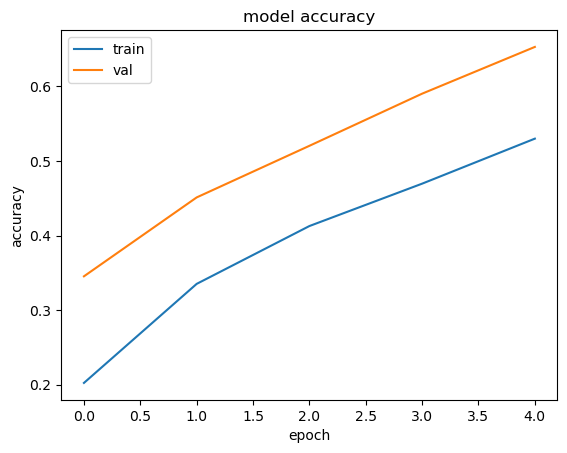

In [98]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

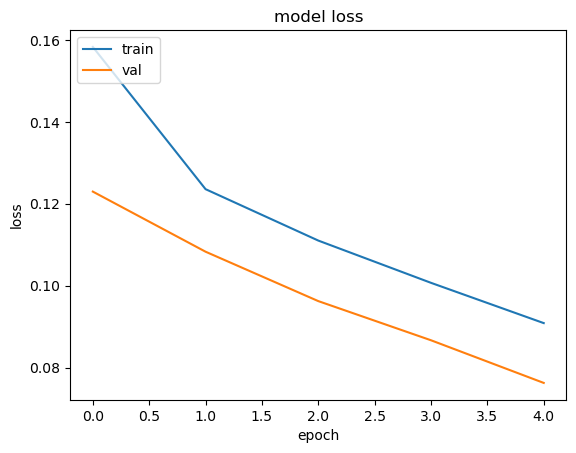

In [99]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [106]:
inference_dataset = val_dataset.take(100)

In [107]:
# Create a model for inference.

# Create a small dataset just for demoing inference.
# inference_dataset = val_dataset.take(100)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch['question']):
    label = label_batch['label'][i].numpy()
    print(f"Abstract: {tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(text))}")
    print(f"Label(s): {invert_multi_hot(label)}")
    predicted_proba = [proba for proba in predicted_probabilities['label']]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities['label'][i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")


Abstract: [CLS] can whopping cough cause problems with breathing or choking in adults i have whopping cough and i am 50 years old i also have wegner is granutomilousis for the past week i have had problems sleeping because i wake up gagging and i can not catch my breath for sometimes over a minute [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Label(s): ['cough']
Predicted Label(s): (coldness, cough, fever)
 
Abstract: [CLS] respridal my son took respridal in 2007 for less than 30 days he has an enhanced chest area should his chest area gone back down after stopping the meds or is it a prolonged side effect of the medication thank you [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [P